Notebook to mess with Bas Nijholt and Anton Akhmerov's calculation method.

In [4]:
import kwant 
import numpy as np
import matplotlib.pyplot as plt
from kwant.continuum import discretize
import annotated_functions as sf
from annotated_functions import constants
import matplotlib as mpl
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})
%matplotlib widget 

In [13]:
a=10
L=400 
L_sc=400
with_leads = True
# Template function for nanowire:
ham = ("(0.5 * hbar**2 * k_x**2 / m_eff * c - mu) * kron(sigma_0, sigma_z) -"
       "alpha * k_x * kron(sigma_y, sigma_z) + "
       "0.5 * g * mu_B * B_x * kron(sigma_x, sigma_0) + Delta * kron(sigma_0, sigma_x)")
#Discretizing template function into tight-binding models:
templ_normal = discretize(ham, locals={'Delta': 0}, grid=a)
templ_sc = discretize(ham, grid=a)
# Lattice and system:
lat = templ_normal.lattice
syst = kwant.Builder()
#Shape function:
def shape(x_left, x_right):
    '''
    Returns:
    lambda function that is true if the x-coordinate of a lattice is within the limits [x_left , x_right), false otherwise.

    tuple (x_left,)
    '''
    return lambda s: x_left <= s.pos[0] < x_right, (x_left,)

syst.fill(templ_sc, *shape(-L_sc, 0));
syst.fill(templ_normal, *shape(0, L));
syst.fill(templ_sc, *shape(L, L+L_sc));
cuts = sf.get_cuts(syst, lat, L//(2*a), (L//(2*a)+1))

parameters = ['hbar' , 'm_eff' , 'mu' , 'alpha' , 'g','mu_B' , 'B_x']
syst = sf.add_vlead(syst, lat, *cuts , parameters)
lead = kwant.Builder(kwant.TranslationalSymmetry([a]))
lead.fill(templ_sc, lambda x: True, (0,))
if with_leads:
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
syst = syst.finalized()
hopping = sf.hopping_between_cuts(syst, *cuts)


/Users/krishnanganesh/Desktop/Josephson Investigations/Josephson effect and Supercurrents/AkhmerovEmailCode/annotated_functions.py:224: RuntimeWarning: divide by zero encountered in double_scalars
  if I_contrib == 0 or tol is not None and abs(I_contrib / I) < tol:


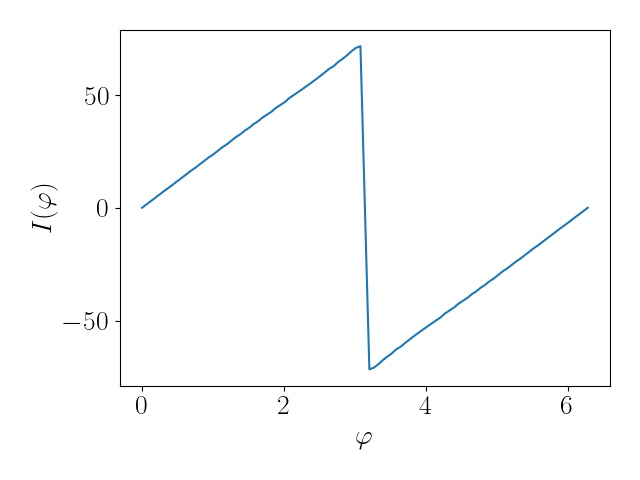

In [14]:
params = dict(T=0.01, Delta=0.2, mu=15, k=constants.k,
              hbar=constants.hbar, m_eff=constants.m_eff, current_unit=constants.current_unit, c=constants.c, 
              B_x=1, B_y=0, B_z=0, g=0, mu_B=0, alpha=0.5, V=lambda x:0)

def plot_CPR(syst, hopping, params, tol=0.01, max_frequencies=1000):
    phases = np.linspace(0, 2*np.pi, 101)
    H_0_cache = []
    I = [sf.current_at_phase(syst, hopping, params, H_0_cache, phase, tol, max_frequencies)
                  for phase in phases]
    fig , ax = plt.subplots()
    ax.plot(phases , I)
    ax.set_xlabel(r'$\varphi$')
    ax.set_ylabel(r'$I(\varphi)$')
    plt.tight_layout()

plot_CPR(syst, hopping, params)


/Users/krishnanganesh/Desktop/Josephson Investigations/Josephson effect and Supercurrents/AkhmerovEmailCode/annotated_functions.py:224: RuntimeWarning: divide by zero encountered in double_scalars
  if I_contrib == 0 or tol is not None and abs(I_contrib / I) < tol:


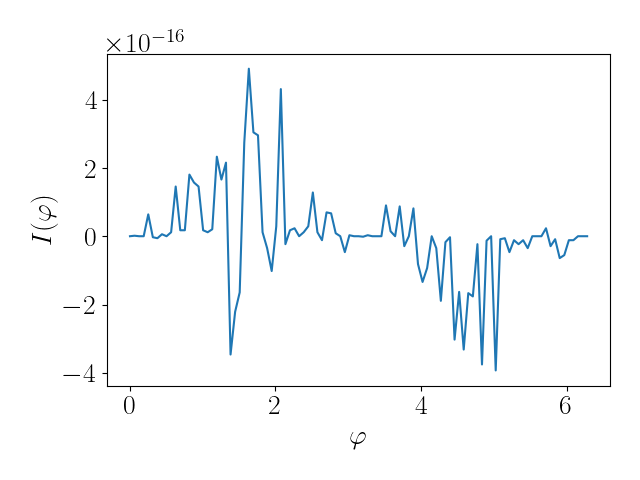

In [29]:
def make_2d_test_system(X=10, Y=1, a=1):
    ham = "(hbar^2 * (k_x^2 + k_y^2) / (2 * m_eff) * c - mu) * sigma_z + Delta * sigma_x"
    template_lead = discretize(ham, grid=a)
    template = discretize(ham, locals={'Delta': 0}, grid=a)
    syst = kwant.Builder()
    syst.fill(template, lambda s: 0 <= s.pos[0] < X and 0 <= s.pos[1] < Y, (0, 0))
    lat = template.lattice

    # Add 0 self energy lead
    cuts = sf.get_cuts(syst, lat)
    syst = sf.add_vlead(syst, lat, *cuts , parameters)

    # Leads
    lead = kwant.Builder(kwant.TranslationalSymmetry((a, 0)))
    lead.fill(template_lead, lambda s: 0 <= s.pos[1] < Y, (0, 0))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()

    hopping = sf.hopping_between_cuts(syst, *cuts)
    return syst, hopping

params = dict(T=0.01, Delta=10, mu=15, k=constants.k,
              hbar=constants.hbar, m_eff=constants.m_eff, current_unit=constants.current_unit, c=constants.c, 
              B_x=1, B_y=0, B_z=0, g=0, mu_B=0, alpha=0.5, V=lambda x:0)
syst, hopping = make_2d_test_system()

plot_CPR(syst, hopping, params)